In [2]:
import sklearn as sk
import numpy as np
import torch
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import warnings

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")
matplotlib.rc("font",family='YouYuan')

# 数据准备

In [3]:
ML_ready=pd.read_csv(".\\ML_ready.csv")
ML_ready['planet_to_star_radius'] = ML_ready['planet_radius'] / ML_ready['star_radius']
ML_ready['star_density'] = ML_ready['star_mass'] / (ML_ready['star_radius'] ** 3)
ML_ready['j_minus_k'] = ML_ready['j_mag'] - ML_ready['k_mag']
ML_ready['h_minus_k'] = ML_ready['h_mag'] - ML_ready['k_mag']
#ML_ready['log_planet_radius'] = np.log1p(ML_ready['planet_radius'])
#ML_ready['log_orbital_period'] = np.log1p(ML_ready['orbital_period'])
#ML_ready['log_star_mass'] = np.log1p(ML_ready['star_mass'])
ML_ready['radius_times_period'] = ML_ready['planet_radius'] * ML_ready['orbital_period']
ML_ready['radius_over_mass'] = ML_ready['planet_radius'] / ML_ready['star_mass']
# 去除高度共线性的变量
ML_ready=ML_ready.drop('k_mag',axis=1)
ML_ready=ML_ready.drop('h_mag',axis=1)
ML_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19761 entries, 0 to 19760
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PC1                    19761 non-null  float64
 1   PC2                    19761 non-null  float64
 2   PC3                    19761 non-null  float64
 3   label                  19761 non-null  int64  
 4   ra                     19761 non-null  float64
 5   dec                    19761 non-null  float64
 6   j_mag                  19761 non-null  float64
 7   kep_mag                19761 non-null  float64
 8   planet_radius          19761 non-null  float64
 9   orbital_period         19761 non-null  float64
 10  star_teff              19761 non-null  float64
 11  star_logg              19761 non-null  float64
 12  star_radius            19761 non-null  float64
 13  star_mass              19761 non-null  float64
 14  lc_time0               19761 non-null  float64
 15  pl

In [4]:
ML_ready.info()
ML_ready.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19761 entries, 0 to 19760
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PC1                    19761 non-null  float64
 1   PC2                    19761 non-null  float64
 2   PC3                    19761 non-null  float64
 3   label                  19761 non-null  int64  
 4   ra                     19761 non-null  float64
 5   dec                    19761 non-null  float64
 6   j_mag                  19761 non-null  float64
 7   kep_mag                19761 non-null  float64
 8   planet_radius          19761 non-null  float64
 9   orbital_period         19761 non-null  float64
 10  star_teff              19761 non-null  float64
 11  star_logg              19761 non-null  float64
 12  star_radius            19761 non-null  float64
 13  star_mass              19761 non-null  float64
 14  lc_time0               19761 non-null  float64
 15  pl

,PC1,PC2,PC3,label,ra,dec,j_mag,kep_mag,planet_radius,orbital_period,...,star_logg,star_radius,star_mass,lc_time0,planet_to_star_radius,star_density,j_minus_k,h_minus_k,radius_times_period,radius_over_mass
0,-0.329993,-0.469118,-0.051703,2,297.00482,48.134129,14.254,15.436,14.60,19.899140,...,4.544,0.868,0.961,175.850252,16.820276,1.469482,0.428,0.074,290.527443,15.192508
1,0.093289,-0.453369,0.408759,2,285.53461,48.285210,14.326,15.597,33.46,1.736952,...,4.564,0.791,0.836,170.307565,42.300885,1.689183,0.517,0.102,58.118429,40.023923
2,-0.469821,-0.455314,0.015327,0,288.75488,48.226200,14.366,15.509,2.75,2.525592,...,4.438,1.046,1.095,171.595550,2.629063,0.956795,0.414,0.112,6.945377,2.511416
3,-0.296522,0.062012,0.022569,0,296.28613,48.224670,14.528,15.714,3.90,11.094321,...,4.486,0.972,1.053,171.201160,4.012346,1.146647,0.396,-0.019,43.267850,3.703704
4,-0.399275,-0.189558,0.008973,0,296.28613,48.224670,14.528,15.714,2.77,4.134435,...,4.486,0.972,1.053,172.979370,2.849794,1.146647,0.396,-0.019,11.452385,2.630579


In [5]:
numeric_features = ['PC1', 'PC2', 'PC3', 'j_mag', 'kep_mag', 
                   'planet_radius', 'orbital_period', 'star_teff', 'star_logg', 
                   'star_radius', 'star_mass', 'lc_time0','planet_to_star_radius','star_density',
                   'j_minus_k','h_minus_k','radius_times_period','radius_over_mass']
# 检查是否需要标准化
print("特征值范围检查：")

feature_ranges = ML_ready[numeric_features].agg(['min', 'max', 'std'])
print(feature_ranges)

# 检查数据平衡性
class_balance = ML_ready['label'].value_counts(normalize=True)
print(f"\n类别平衡性：")
print(class_balance)

if class_balance.min() < 0.1:  # 如果最小类别占比小于10%
    print("警告：数据可能存在类别不平衡问题")

特征值范围检查：
           PC1        PC2       PC3      j_mag    kep_mag  planet_radius  \
min  -0.591683  -2.864373 -7.777481   4.097000   4.627800       0.036257   
max  13.803377  24.012589  7.424680  17.372000  20.003000   26042.900000   
std   1.024262   0.799844  0.503856   1.232746   1.964285     198.858223   

     orbital_period     star_teff  star_logg  star_radius  star_mass  \
min        0.152076   2520.000000   0.047000     0.109000   0.000000   
max    83830.000000  50000.000000   5.960650   229.908000  14.336000   
std      606.676580   1165.439181   0.345673     4.335476   0.261247   

         lc_time0  planet_to_star_radius  star_density  j_minus_k  h_minus_k  \
min  1.205659e+02               0.054041      0.000000  -0.744000  -1.834000   
max  2.460863e+06            2693.164426    716.754320   5.137000   2.942000   
std  1.208171e+06              47.709361     15.009019   0.154479   0.069509   

     radius_times_period  radius_over_mass  
min             0.009825       

In [6]:
# 由于1类——Candidate没有什么实际意义（仅仅是暂时无法确认，但是最终会被确认），因此在训练分类模型和测试时不考虑这一类
ML_ready_used=ML_ready[ML_ready["label"]!=1]

#处理无穷大数据
infinite_mask = np.isinf(ML_ready_used)
    

infinite_counts = infinite_mask.sum()
columns_with_infinite = infinite_counts[infinite_counts > 0]

# 统计含有无穷大值的行数
rows_with_infinite = infinite_mask.any(axis=1)
count_rows_with_infinite = rows_with_infinite.sum()
    
print(f"\n含有无穷大值的行数: {count_rows_with_infinite}")
print(f"总行数: {len(ML_ready_used)}")
    

# 删除含有无穷大值的行
ML_ready_used= ML_ready_used[~rows_with_infinite].copy()

# 准备特征和目标变量
X = ML_ready_used.drop('label', axis=1)
y = ML_ready_used['label']


print(f"特征维度: {X.shape}")
print(f"目标变量维度: {y.shape}")



含有无穷大值的行数: 1
总行数: 12348
特征维度: (12347, 20)
目标变量维度: (12347,)


# 机器学习算法和超参数调优

In [7]:
# 分割数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 只对数值特征进行标准化
X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

print(f"训练集大小: {X_train.shape}")
print(f"测试集大小: {X_test.shape}")
print(f"类别分布:\n{y.value_counts(normalize=True)}")

训练集大小: (9877, 20)
测试集大小: (2470, 20)
类别分布:
label
0    0.511136
2    0.487082
3    0.001782
Name: proportion, dtype: float64


In [8]:
ML_ready_used.info()
# 检查数据平衡性
class_balance = ML_ready_used['label'].value_counts(normalize=True)
print(f"\n类别平衡性：")
print(class_balance)


<class 'pandas.core.frame.DataFrame'>
Index: 12347 entries, 0 to 19737
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PC1                    12347 non-null  float64
 1   PC2                    12347 non-null  float64
 2   PC3                    12347 non-null  float64
 3   label                  12347 non-null  int64  
 4   ra                     12347 non-null  float64
 5   dec                    12347 non-null  float64
 6   j_mag                  12347 non-null  float64
 7   kep_mag                12347 non-null  float64
 8   planet_radius          12347 non-null  float64
 9   orbital_period         12347 non-null  float64
 10  star_teff              12347 non-null  float64
 11  star_logg              12347 non-null  float64
 12  star_radius            12347 non-null  float64
 13  star_mass              12347 non-null  float64
 14  lc_time0               12347 non-null  float64
 15  planet_

## 各模型尝试

In [16]:
# 初始化分类器
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss')
}

# 存储结果
basic_results = {}

print("开始训练各种分类器...")
print("=" * 50)

for name, clf in classifiers.items():
    print(f"训练 {name}...")
    
    # 选择是否使用标准化数据
    if name in ['Logistic Regression', 'SVM', 'K-Nearest Neighbors']:
        X_tr = X_train_scaled
        X_te = X_test_scaled
    else:
        X_tr = X_train
        X_te = X_test
    
    # 对于XGBoost，需要特殊处理类别标签
    if name == 'XGBoost':
        # 获取唯一的类别标签
        unique_classes = sorted(np.unique(y_train))
        
        # 创建映射字典：原始标签 -> 连续整数
        class_mapping = {orig_label: new_label for new_label, orig_label in enumerate(unique_classes)}
        
        # 创建反向映射：连续整数 -> 原始标签
        reverse_mapping = {new_label: orig_label for orig_label, new_label in class_mapping.items()}
        
        # 转换训练标签
        y_train_xgb = np.array([class_mapping[label] for label in y_train])
        y_test_xgb = np.array([class_mapping[label] for label in y_test])
        
        # 计算类别数量
        num_classes = len(unique_classes)
        
        # 重新初始化XGBoost，指定类别数量
        clf = XGBClassifier(
            random_state=42, 
            eval_metric='mlogloss',
            num_class=num_classes,
            objective='multi:softprob'
        )
        
        # 使用转换后的标签训练
        clf.fit(X_tr, y_train_xgb)
        
        # 预测
        y_pred_xgb = clf.predict(X_te)
        
        # 将预测结果转换回原始标签
        y_pred = np.array([reverse_mapping[label] for label in y_pred_xgb])
        
        # 计算准确率（使用原始标签比较）
        accuracy = accuracy_score(y_test, y_pred)
        
        # 交叉验证（使用转换后的标签）
        cv_scores = cross_val_score(clf, X_tr, y_train_xgb, cv=5, scoring='accuracy')
        
    else:
        # 对于其他分类器，直接使用原始标签
        clf.fit(X_tr, y_train)
        
        # 预测
        y_pred = clf.predict(X_te)
        
        # 计算准确率
        accuracy = accuracy_score(y_test, y_pred)
        
        # 交叉验证
        cv_scores = cross_val_score(clf, X_tr, y_train, cv=5, scoring='accuracy')
    
    # 存储结果
    basic_results[name] = {
        'model': clf,
        'accuracy': accuracy,
        'predictions': y_pred,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"{name}: 测试准确率 = {accuracy:.4f}, 交叉验证准确率 = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

开始训练各种分类器...
训练 Logistic Regression...
Logistic Regression: 测试准确率 = 0.7283, 交叉验证准确率 = 0.7313 (±0.0090)
训练 Random Forest...
Random Forest: 测试准确率 = 0.9105, 交叉验证准确率 = 0.8973 (±0.0071)
训练 Gradient Boosting...
Gradient Boosting: 测试准确率 = 0.8903, 交叉验证准确率 = 0.8838 (±0.0030)
训练 SVM...
SVM: 测试准确率 = 0.8077, 交叉验证准确率 = 0.8015 (±0.0121)
训练 K-Nearest Neighbors...
K-Nearest Neighbors: 测试准确率 = 0.8101, 交叉验证准确率 = 0.7987 (±0.0054)
训练 Decision Tree...
Decision Tree: 测试准确率 = 0.8486, 交叉验证准确率 = 0.8424 (±0.0053)
训练 Naive Bayes...
Naive Bayes: 测试准确率 = 0.3992, 交叉验证准确率 = 0.4200 (±0.0202)
训练 XGBoost...
XGBoost: 测试准确率 = 0.9194, 交叉验证准确率 = 0.9062 (±0.0027)


## 超参数调优

In [13]:
# 定义超参数搜索空间
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300, 500],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5, 6],
        'min_samples_split': [2, 5, 10],
        'subsample': [0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5 , 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    }
}

# 创建基础分类器，针对XGBoost特殊处理
base_classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': None  # 我们稍后动态创建，因为需要知道类别数量
}

# 存储结果
results = {}
best_params = {}

print("开始训练三种模型并进行超参数调优...")
print("=" * 60)

# 对于XGBoost，需要特殊处理类别标签
def prepare_labels_for_xgboost(y):
    """将不连续的类别标签映射为连续的，供XGBoost使用"""
    unique_classes = sorted(np.unique(y))
    class_mapping = {orig_label: new_label for new_label, orig_label in enumerate(unique_classes)}
    reverse_mapping = {new_label: orig_label for orig_label, new_label in class_mapping.items()}
    return class_mapping, reverse_mapping

# 创建XGBoost需要的映射
class_mapping, reverse_mapping = prepare_labels_for_xgboost(y_train)
num_classes = len(np.unique(y_train))

# 转换训练和测试标签（仅用于XGBoost）
y_train_xgb = np.array([class_mapping[label] for label in y_train])
y_test_xgb = np.array([class_mapping[label] for label in y_test])

print(f"XGBoost使用的类别映射:")
for orig, new in class_mapping.items():
    print(f"  原始标签 {orig} -> XGBoost标签 {new}")

# 现在开始训练各个模型
for name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    print(f"\n正在调优 {name}...")
    
    # 获取该模型的参数网格
    param_grid = param_grids.get(name, {})
    
    # 根据模型选择数据和标签
    if name == 'XGBoost':
        # 创建XGBoost分类器
        base_clf = XGBClassifier(
            random_state=42, 
            eval_metric='mlogloss',
            num_class=num_classes,
            objective='multi:softprob'
        )
        
        # 使用转换后的标签
        y_tr = y_train_xgb
        y_te = y_test_xgb
        y_te_original = y_test  # 用于最终评估的原始标签
        
        # 使用默认数据（不标准化）
        X_tr = X_train
        X_te = X_test
        
    else:
        # 对于其他分类器，使用原始分类器
        base_clf = base_classifiers[name]
        
        # 使用原始标签
        y_tr = y_train
        y_te = y_test
        y_te_original = y_test
        
        # 使用默认数据（不标准化）
        X_tr = X_train
        X_te = X_test
    
    # 使用随机搜索，减少迭代次数
    # 对于较小的数据集，我们可以使用更少的交叉验证折数
    cv_folds = min(3, len(y_train) // 10)  # 确保每个折至少有10个样本
    cv_folds = max(2, cv_folds)  # 至少2折
    
    search = RandomizedSearchCV(
        base_clf, param_grid, n_iter=10,  # 减少迭代次数
        cv=cv_folds,  # 使用更少的交叉验证折数
        scoring='accuracy', 
        n_jobs=-1,  # 使用所有可用的CPU核心
        random_state=42, 
        verbose=1,  # 显示进度
        error_score='raise'  # 如果有错误就抛出，方便调试
    )
    
    print(f"  使用 {cv_folds} 折交叉验证")
    
    
    # 执行超参数搜索
    search.fit(X_tr, y_tr)
    
    # 获取最佳模型和参数
    best_clf = search.best_estimator_
    best_params[name] = search.best_params_
    
    # 使用最佳模型进行预测
    y_pred = best_clf.predict(X_te)
    
    # 对于XGBoost，需要将预测结果映射回原始标签
    if name == 'XGBoost':
        y_pred = np.array([reverse_mapping[label] for label in y_pred])
        # 使用原始标签进行评估
        accuracy = accuracy_score(y_te_original, y_pred)
    else:
        accuracy = accuracy_score(y_te_original, y_pred)
    
    # 使用最佳参数进行交叉验证（减少折数以加快速度）
    cv_folds_eval = min(5, len(y_tr) // 10)
    cv_folds_eval = max(3, cv_folds_eval)
    
    if name == 'XGBoost':
        cv_scores = cross_val_score(best_clf, X_tr, y_tr, cv=cv_folds_eval, scoring='accuracy', n_jobs=-1)
    else:
        cv_scores = cross_val_score(best_clf, X_tr, y_tr, cv=cv_folds_eval, scoring='accuracy', n_jobs=-1)
    
    # 存储结果
    results[name] = {
        'model': best_clf,
        'accuracy': accuracy,
        'predictions': y_pred,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'best_params': search.best_params_
    }
    
    print(f"{name} 调优完成:")
    print(f"  最佳参数: {search.best_params_}")
    print(f"  测试准确率 = {accuracy:.4f}")
    print(f"  交叉验证准确率 = {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

print("\n" + "=" * 60)
print("所有模型训练和调优完成！")

# 输出最佳模型比较
print("\n模型性能比较:")
print("-" * 60)
sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
for i, (name, result) in enumerate(sorted_results, 1):
    print(f"{i:2d}. {name:25} 测试准确率: {result['accuracy']:.4f}  CV准确率: {result['cv_mean']:.4f} (±{result['cv_std']:.4f})")

# 找到最佳模型
best_model_name, best_model_result = sorted_results[0]
print(f"\n🎯 最佳模型: {best_model_name}")
print(f"📊 最佳测试准确率: {best_model_result['accuracy']:.4f}")
print(f"⚙️  最佳参数: {best_model_result['best_params']}")

开始训练三种模型并进行超参数调优...
XGBoost使用的类别映射:
  原始标签 0 -> XGBoost标签 0
  原始标签 2 -> XGBoost标签 1
  原始标签 3 -> XGBoost标签 2

正在调优 Random Forest...
  使用 3 折交叉验证
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Forest 调优完成:
  最佳参数: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 20}
  测试准确率 = 0.9146
  交叉验证准确率 = 0.8988 (±0.0071)

正在调优 Gradient Boosting...
  使用 3 折交叉验证
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Gradient Boosting 调优完成:
  最佳参数: {'subsample': 1.0, 'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 6, 'learning_rate': 0.2}
  测试准确率 = 0.9154
  交叉验证准确率 = 0.9002 (±0.0047)

正在调优 XGBoost...
  使用 3 折交叉验证
Fitting 3 folds for each of 10 candidates, totalling 30 fits
XGBoost 调优完成:
  最佳参数: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
  测试准确率 = 0.9198
  交叉验证准确率 = 0.9069 (±0.0024)

所有模型训练和调优完成！

模型性能比较:
----------------------------------------------

In [17]:
print("模型性能对比表")
print("=" * 60)

# 创建对比表格
comparison = []
for model_name in basic_results.keys():
    # 获取调优前性能
    pre_perf = basic_results[model_name]
    pre_acc = pre_perf['accuracy']
    pre_cv = pre_perf['cv_mean']
    
    # 获取调优后性能（如果存在）
    if model_name in results:
        post_perf = results[model_name]
        post_acc = post_perf['accuracy']
        post_cv = post_perf['cv_mean']
        improvement = post_acc - pre_acc
        tuned = "✓"
    else:
        post_acc = post_cv = np.nan
        improvement = np.nan
        tuned = ""
    
    comparison.append({
        '模型': model_name,
        '调优': tuned,
        '调优前准确率': f"{pre_acc:.4f}",
        '调优后准确率': f"{post_acc:.4f}" if not np.isnan(post_acc) else "-",
        '提升': f"{improvement:+.4f}" if not np.isnan(improvement) else "-",
        '调优前CV': f"{pre_cv:.4f}",
        '调优后CV': f"{post_cv:.4f}" if not np.isnan(post_cv) else "-"
    })

# 创建DataFrame并排序
df_comparison = pd.DataFrame(comparison)

# 排序：先按是否调优，再按调优后准确率（或调优前准确率）
def get_sort_value(row):
    if row['调优后准确率'] != '-':
        return float(row['调优后准确率'])
    else:
        return float(row['调优前准确率'])

df_comparison['排序值'] = df_comparison.apply(get_sort_value, axis=1)
df_comparison = df_comparison.sort_values('排序值', ascending=False).drop('排序值', axis=1)

print(df_comparison.to_string(index=False))

# 分析调优效果
tuned_models = [name for name in basic_results.keys() if name in results]
if tuned_models:
    print("超参数调优效果：")
    for model in tuned_models:
        pre = basic_results[model]['accuracy']
        post = results[model]['accuracy']
        change = post - pre
        print(f"  {model}: {pre:.4f} → {post:.4f} ({change:+.4f})")
        
        if change > 0.02:
            print("     显著提升！")
        elif change > 0:
            print("     略有提升")
        elif change < 0:
            print("     性能下降")

# 找到最佳模型
best_model = df_comparison.iloc[0]['模型']
best_acc = df_comparison.iloc[0]['调优后准确率'] if df_comparison.iloc[0]['调优'] == "✓" else df_comparison.iloc[0]['调优前准确率']
print(f"\n最佳模型: {best_model} (准确率: {best_acc})")

模型性能对比表
                 模型 调优 调优前准确率 调优后准确率      提升  调优前CV  调优后CV
            XGBoost  ✓ 0.9194 0.9198 +0.0004 0.9062 0.9069
  Gradient Boosting  ✓ 0.8903 0.9154 +0.0251 0.8838 0.9002
      Random Forest  ✓ 0.9105 0.9146 +0.0040 0.8973 0.8988
      Decision Tree    0.8486      -       - 0.8424      -
K-Nearest Neighbors    0.8101      -       - 0.7987      -
                SVM    0.8077      -       - 0.8015      -
Logistic Regression    0.7283      -       - 0.7313      -
        Naive Bayes    0.3992      -       - 0.4200      -
超参数调优效果：
  Random Forest: 0.9105 → 0.9146 (+0.0040)
     略有提升
  Gradient Boosting: 0.8903 → 0.9154 (+0.0251)
     显著提升！
  XGBoost: 0.9194 → 0.9198 (+0.0004)
     略有提升

最佳模型: XGBoost (准确率: 0.9198)



最佳模型: XGBoost
详细分类报告:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1263
           2       0.93      0.91      0.92      1203
           3       1.00      0.75      0.86         4

    accuracy                           0.92      2470
   macro avg       0.95      0.86      0.90      2470
weighted avg       0.92      0.92      0.92      2470

超参数调整前混淆矩阵：

实际类别标签: [np.int64(0), np.int64(2), np.int64(3)]

混淆矩阵 (数值格式):
       预测: 0  预测: 2  预测: 3
真实: 0   1173     90      0
真实: 2    107   1096      0
真实: 3      2      0      2


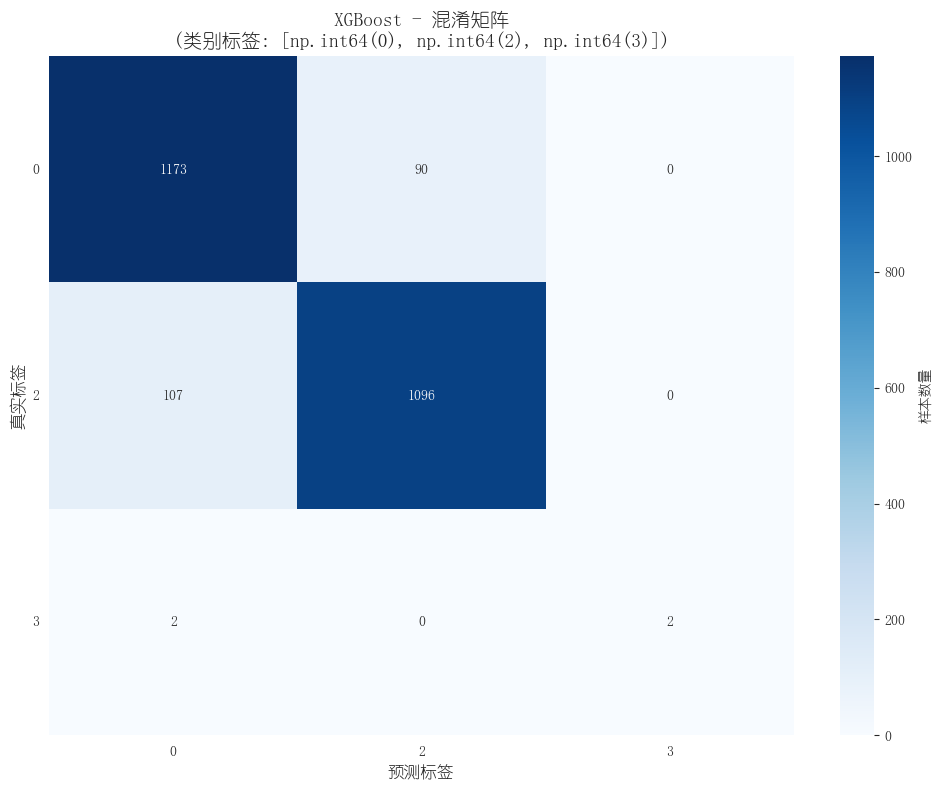

超参数调整后混淆矩阵：

实际类别标签: [np.int64(0), np.int64(2), np.int64(3)]

混淆矩阵 (数值格式):
       预测: 0  预测: 2  预测: 3
真实: 0   1179     84      0
真实: 2    113   1090      0
真实: 3      1      0      3


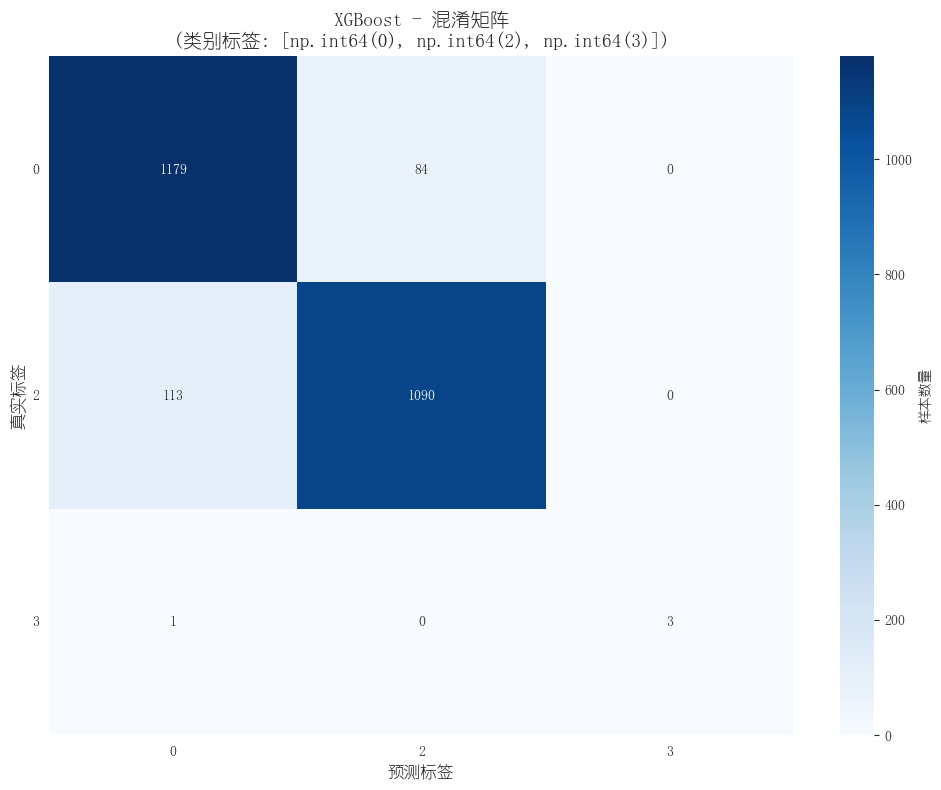

In [22]:
# 选择最佳模型
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['predictions']
basic_best_predictions=basic_results[best_model_name]['predictions']
print(f"\n最佳模型: {best_model_name}")
print("=" * 50)

# 详细分类报告
print("详细分类报告:")
print(classification_report(y_test, best_predictions))

def cm_to_show(y_test,best_predictions,best_model_name):
    '''
    绘制混淆矩阵，因为用的是XGBoost，需要考虑类别变换
    '''
    if best_model_name=="XGBoost":
        labels = sorted(np.unique(np.concatenate([y_test, best_predictions])))
        print(f"实际类别标签: {labels}")
    # 计算混淆矩阵
    cm = confusion_matrix(y_test, best_predictions, labels=labels)

    # 将混淆矩阵转换为DataFrame，便于显示
    cm_df = pd.DataFrame(cm, 
                     index=[f'真实: {label}' for label in labels],
                     columns=[f'预测: {label}' for label in labels])

    print("\n混淆矩阵 (数值格式):")
    print(cm_df)

    # 可视化混淆矩阵
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': '样本数量'})

    plt.title(f'{best_model_name} - 混淆矩阵\n(类别标签: {labels})', fontsize=14, fontweight='bold')
    plt.ylabel('真实标签', fontsize=12)
    plt.xlabel('预测标签', fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

print("超参数调整前混淆矩阵：\n")
cm_to_show(y_test,basic_best_predictions,best_model_name)
print("超参数调整后混淆矩阵：\n")
cm_to_show(y_test,best_predictions,best_model_name)


调超参数反而让模型在0、2类的表现更差，但是由于在3类上表现更好，模型的最终准确率更高

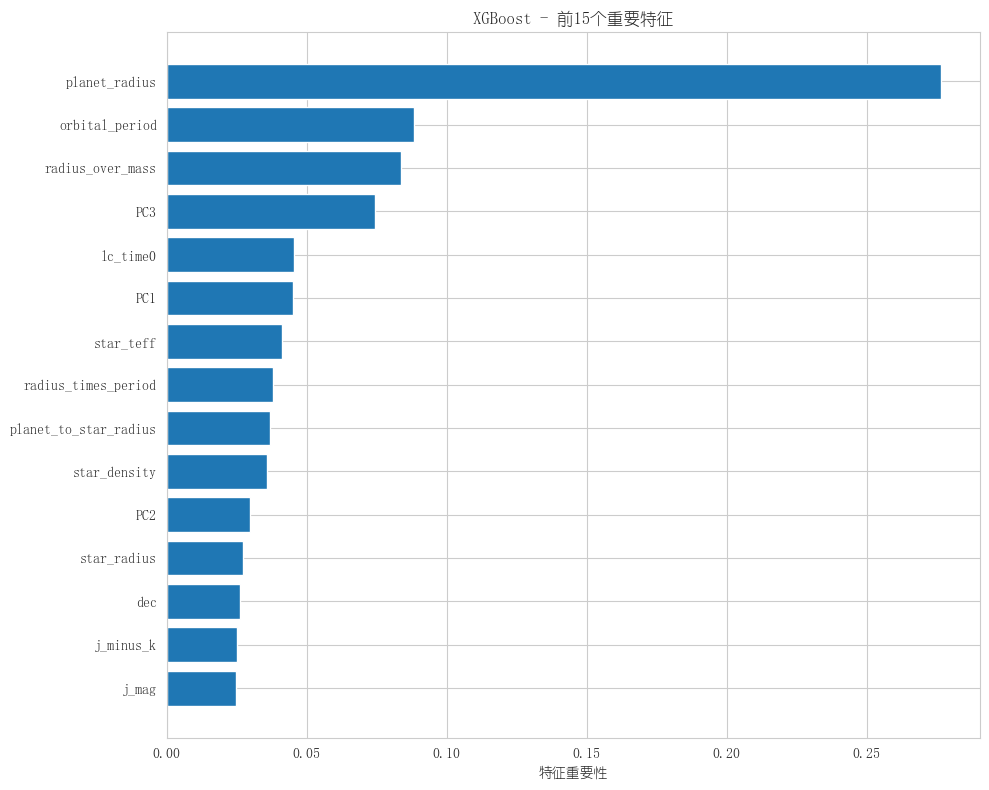

前10个最重要特征:
                  feature  importance
7           planet_radius    0.276572
8          orbital_period    0.088374
19       radius_over_mass    0.083490
2                     PC3    0.074316
13               lc_time0    0.045460
0                     PC1    0.045183
9               star_teff    0.041044
18    radius_times_period    0.038022
14  planet_to_star_radius    0.036890
15           star_density    0.035642


In [21]:
# 如果最佳模型是树模型，分析特征重要性
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importance['feature'][:15], 
             feature_importance['importance'][:15])
    plt.xlabel('特征重要性')
    plt.title(f'{best_model_name} - 前15个重要特征')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print("前10个最重要特征:")
    print(feature_importance.head(10))

# 保存结果：

In [23]:
from datetime import datetime
import joblib
import json


def save_model_results_joblib(results_dict, basic_results_dict, save_dir='model_results'):
    """
    使用joblib保存模型结果（对大模型更高效）
    
    参数:
    results_dict: 调优后的结果字典
    basic_results_dict: 调优前的结果字典
    save_dir: 保存目录
    """
    
    # 创建保存目录
    os.makedirs(save_dir, exist_ok=True)
    os.makedirs(os.path.join(save_dir, 'models'), exist_ok=True)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. 保存模型对象（使用joblib）
    models_info = {}
    
    for model_name, model_info in results_dict.items():
        if 'model' in model_info:
            model = model_info['model']
            model_path = os.path.join(save_dir, 'models', f"{model_name}_{timestamp}.joblib")
            joblib.dump(model, model_path)
            models_info[model_name] = model_path
    
    # 2. 保存结果数据（不含模型对象，使用JSON/CSV）
    results_data = {}
    for model_name, model_info in results_dict.items():
        results_data[model_name] = {
            'accuracy': float(model_info.get('accuracy', 0)),
            'cv_mean': float(model_info.get('cv_mean', 0)),
            'cv_std': float(model_info.get('cv_std', 0)),
            'best_params': model_info.get('best_params', {}),
            'model_path': models_info.get(model_name, '')
        }
    
    basic_results_data = {}
    for model_name, model_info in basic_results_dict.items():
        basic_results_data[model_name] = {
            'accuracy': float(model_info.get('accuracy', 0)),
            'cv_mean': float(model_info.get('cv_mean', 0)),
            'cv_std': float(model_info.get('cv_std', 0))
        }
    
    # 保存为JSON
    json_data = {
        'results': results_data,
        'basic_results': basic_results_data,
        'timestamp': timestamp,
        'model_paths': models_info
    }
    
    json_path = os.path.join(save_dir, f'model_results_{timestamp}.json')
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(json_data, f, ensure_ascii=False, indent=2)
    
    print(f" JSON结果已保存到: {json_path}")
    
    # 3. 创建性能对比表格
    performance_data = []
    
    all_models = set(list(results_dict.keys()) + list(basic_results_dict.keys()))
    
    for model_name in all_models:
        row = {'模型名称': model_name}
        
        if model_name in basic_results_dict:
            basic = basic_results_dict[model_name]
            row['调优前准确率'] = basic.get('accuracy')
            row['调优前CV均值'] = basic.get('cv_mean')
        
        if model_name in results_dict:
            result = results_dict[model_name]
            row['调优后准确率'] = result.get('accuracy')
            row['调优后CV均值'] = result.get('cv_mean')
            row['是否调优'] = '是'
            
            # 如果有最佳参数，添加到行
            best_params = result.get('best_params')
            if best_params:
                for param, value in best_params.items():
                    row[f'最佳_{param}'] = value
        else:
            row['是否调优'] = '否'
        
        performance_data.append(row)
    
    # 保存为CSV
    df_performance = pd.DataFrame(performance_data)
    csv_path = os.path.join(save_dir, f'performance_comparison_{timestamp}.csv')
    df_performance.to_csv(csv_path, index=False, encoding='utf-8-sig')
    
    print(f" 性能对比表格已保存到: {csv_path}")
    
    # 4. 创建汇总报告
    report_path = os.path.join(save_dir, f'summary_report_{timestamp}.txt')
    
    with open(report_path, 'w', encoding='utf-8') as f:
        f.write("模型结果保存汇总\n")
        f.write("=" * 60 + "\n")
        f.write(f"保存时间: {timestamp}\n")
        f.write(f"保存目录: {save_dir}\n\n")
        
        f.write("已保存的模型文件:\n")
        for model_name, model_path in models_info.items():
            f.write(f"  {model_name}: {model_path}\n")
        
        f.write(f"\n总共保存了 {len(models_info)} 个模型对象\n")
    
    print(f" 汇总报告已保存到: {report_path}")
    
    return {
        'json_results': json_path,
        'csv_performance': csv_path,
        'summary_report': report_path,
        'model_paths': models_info
    }

# 使用示例
if __name__ == "__main__":
    saved_files = save_model_results_joblib(results, basic_results)
    
    print("\n 所有文件保存完成:")
    for file_type, file_path in saved_files.items():
        if file_type != 'model_paths':
            print(f"  {file_type}: {file_path}")
    
    print("\n 已保存的模型:")
    for model_name, model_path in saved_files['model_paths'].items():
        print(f"  {model_name}: {model_path}")

 JSON结果已保存到: model_results\model_results_20251202_114238.json
 性能对比表格已保存到: model_results\performance_comparison_20251202_114238.csv
 汇总报告已保存到: model_results\summary_report_20251202_114238.txt

 所有文件保存完成:
  json_results: model_results\model_results_20251202_114238.json
  csv_performance: model_results\performance_comparison_20251202_114238.csv
  summary_report: model_results\summary_report_20251202_114238.txt

 已保存的模型:
  Random Forest: model_results\models\Random Forest_20251202_114238.joblib
  Gradient Boosting: model_results\models\Gradient Boosting_20251202_114238.joblib
  XGBoost: model_results\models\XGBoost_20251202_114238.joblib


# 将训练出来的模型应用于类别1，进行分类尝试

In [34]:
# 1. 复制原始数据，避免修改原数据
ML_ready_new = ML_ready.copy()

print(f"原始数据形状: {ML_ready.shape}")
print(f"类别1的样本数量: {len(ML_ready[ML_ready['label'] == 1])}")
print(f"所有类别分布:")
print(ML_ready['label'].value_counts().sort_index())

# 2. 提取原标签为1的样本进行预测
X_new = ML_ready[ML_ready['label'] == 1].drop('label', axis=1)
print(f"\n待预测的样本数量: {X_new.shape[0]}")

# 检查是否存在无限大值
if X_new.select_dtypes(include=[np.number]).applymap(np.isinf).sum().sum() > 0:
    print("警告: 待预测数据中存在无穷大值，需要进行处理")
    # 清理无穷大值（使用训练时的相同处理方式）
    X_new_clean = X_new.replace([np.inf, -np.inf], np.nan).fillna(X_train.median())
    print("已清理无穷大值")
else:
    X_new_clean = X_new

# 3. 使用最佳模型进行预测
best_model = results[best_model_name]['model']
print(f"\n使用模型: {best_model_name}")

y_pred_new_xgb = best_model.predict(X_new_clean)
y_pred_new=np.array([reverse_mapping[label] for label in y_pred_new_xgb])

# 4. 查看预测结果分布
print("\n预测结果分布:")
unique_preds, counts = np.unique(y_pred_new, return_counts=True)
for pred, count in zip(unique_preds, counts):
    print(f"  预测为类别 {pred}: {count} 个样本 ({count/X_new.shape[0]*100:.1f}%)")

# 5. 更新ML_ready_new中的标签
# 找到原标签为1的样本的索引
indices_to_update = ML_ready_new[ML_ready_new['label'] == 1].index

# 使用.loc确保正确更新
ML_ready_new.loc[indices_to_update, 'label'] = y_pred_new

print(f"\n更新完成!")
print(f"更新后的数据形状: {ML_ready_new.shape}")
print(f"更新后的类别分布:")
print(ML_ready_new['label'].value_counts().sort_index())

# 原类别1的样本预测情况
original_label_1_indices = indices_to_update
original_label_1_predictions = y_pred_new

# 统计预测结果
prediction_counts = pd.Series(original_label_1_predictions).value_counts().sort_index()

print(f"原类别1的 {len(original_label_1_predictions)} 个样本被重新预测为:")
for pred_label, count in prediction_counts.items():
    percentage = count / len(original_label_1_predictions) * 100
    print(f"  类别 {pred_label}: {count} 个 ({percentage:.1f}%)")

# 9. 保存结果到文件
print("\n" + "="*50)
print("保存结果")
print("="*50)

import os
from datetime import datetime

# 创建保存目录
save_dir = 'updated_results'
os.makedirs(save_dir, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 保存更新后的数据
updated_file = os.path.join(save_dir, f'ML_ready_updated_{timestamp}.csv')
ML_ready_new.to_csv(updated_file, index=False, encoding='utf-8-sig')
print(f"✅ 更新后的数据已保存到: {updated_file}")

# 保存预测详情
prediction_details = pd.DataFrame({
    'original_index': list(original_label_1_indices),
    'original_label': [1] * len(original_label_1_indices),
    'predicted_label': original_label_1_predictions
})

details_file = os.path.join(save_dir, f'prediction_details_{timestamp}.csv')
prediction_details.to_csv(details_file, index=False, encoding='utf-8-sig')
print(f"✅ 预测详情已保存到: {details_file}")

# 返回更新后的数据
ML_ready_new = ML_ready_new

原始数据形状: (19761, 21)
类别1的样本数量: 7413
所有类别分布:
label
0    6311
1    7413
2    6015
3      22
Name: count, dtype: int64

待预测的样本数量: 7413

使用模型: XGBoost

预测结果分布:
  预测为类别 0: 3750 个样本 (50.6%)
  预测为类别 2: 3662 个样本 (49.4%)
  预测为类别 3: 1 个样本 (0.0%)

更新完成!
更新后的数据形状: (19761, 21)
更新后的类别分布:
label
0    10061
2     9677
3       23
Name: count, dtype: int64
原类别1的 7413 个样本被重新预测为:
  类别 0: 3750 个 (50.6%)
  类别 2: 3662 个 (49.4%)
  类别 3: 1 个 (0.0%)

保存结果
✅ 更新后的数据已保存到: updated_results\ML_ready_updated_20251202_120202.csv
✅ 预测详情已保存到: updated_results\prediction_details_20251202_120202.csv
